# SARIMA Tahmini

## 01 - Arka Plan

Bu zorlukta amacımız, zaman serisi analizinin temel kavramlarını tek boyutlu verilere (tarihe bağlı satışlar) uygulamaktır.

Bu zorlukta aşağıdaki adımları takip edeceğiz:
1. verileri yükle ve görselleştir;
2. modellerimizi eğit ve tahminler yap;
3. seriyi modellemek ve tahmin edebilmek için ekonometrik bir yaklaşım kullan;
4. bu modeli hacklemek için Makine Öğrenmesi kullan.

Veri seti [Machine Learning Mastery](https://github.com/jbrownlee/) tarafından sağlanmıştır. İndirmek için aşağıdaki satırı çalıştırın!

In [1]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1596  100  1596    0     0   3860      0 --:--:-- --:--:-- --:--:--  3873


## 02 - Veri Yükleme
Meydan okumanın zaman serisini yükleyerek başlayalım

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 DataFrame'in "Month" sütununu `Datetime` nesnelerine dönüştürün ve şu şekilde görünmesi için indeks olarak ayarlayın:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [6]:
df["Month"] = pd.to_datetime(df["Month"])


df.set_index("Month", inplace = True)



### Alternatif - Pandas'ın İşi Yapmasına İzin Ver

In [ ]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

## 04 - Veriyi Görselleştir ve Yorumla

Aferin, bu yeniden indeksleme sayesinde artık "Sales" (y-ekseni) değerlerini zamanın (x-ekseni) bir fonksiyonu olarak kolayca çizebilmelisiniz

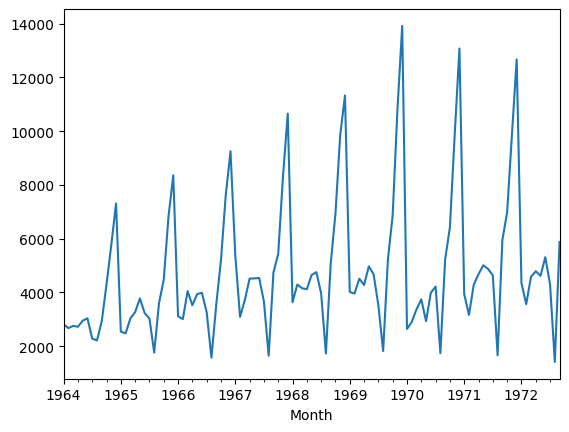

In [9]:
df["Sales"].plot();

Kodunuz doğruysa, bu zaman serisinin (TS) şu özelliklere sahip olduğunu görebilmelisiniz:
- Durağan değil (ortalama ve varyans sabit değil).
- Güçlü mevsimsellik sergiliyor.
- Bir trend var gibi görünüyor.

Verilerin **trend**, **mevsimsellik** ve **gürültü** arasındaki ayrışımını görelim. Bunun için statsmodels'ın [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) fonksiyonunu kullanmalısınız. Dokümanları okuyun ve bu fonksiyonun ne yaptığını ve nasıl kullanıldığını anladığınızdan emin olun, ardından:
1. "Sales"i "additive" model ile çizin
2. "Sales"i "multiplicative" model ile çizin

Profesyonel ipuçları: çift çizim sorunlarını önlemek için statsmodels plot metot çağrılarınızı noktalı virgülle (`;`) bitirin!

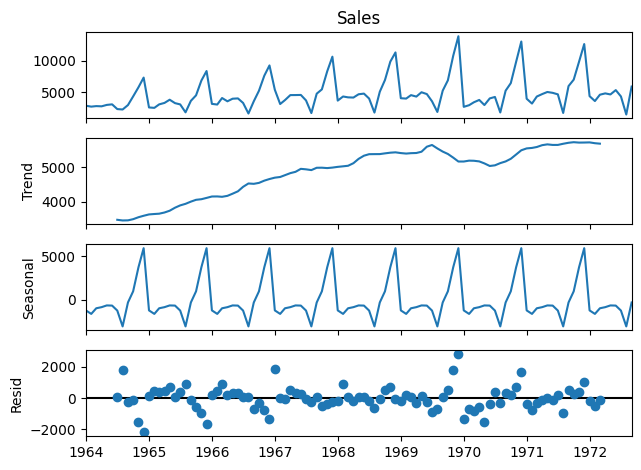

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Additive Model
result_add = seasonal_decompose(df['Sales'], model='additive', period=12)
result_add.plot();


👉 Seçtiğiniz ayrışımı kullanarak bu zaman serisini mevsimsellikten arındırın

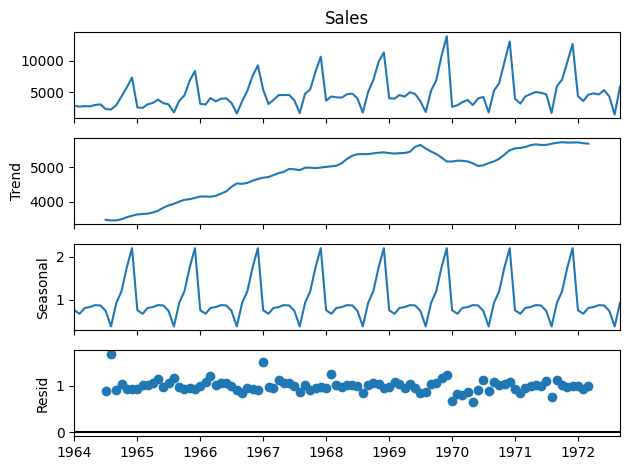

In [12]:
# 2. Multiplicative Model
result_mul = seasonal_decompose(df['Sales'], model='multiplicative', period=12)
result_mul.plot();

☝️ Bu zaman serisinin "mevsimsellikten arındırılmış" versiyonuna bir ARIMA modeli uydurabilir ve tahminimizden sonra tekrar birleştirebiliriz. Ancak bu meydan okumada, orijinal zaman serisine _doğrudan_ uydurmak için SARIMA modellerini kullanacağız!

## 05 - Veriyi Böl (eğitim/test)


Zaman serileri için test setinde bulunacak noktaları rastgele örnekleyemeyiz. Test setinin "zaman-dışı" olması gerekir, yani test setinin kesinlikle geleceğinde olmalıdır. Bu egzersiz için eğitim için 1970'e kadar olan verileri kullanacağız ve bundan sonraki her şey test için kullanılacak.

👉 `df_train` ve `df_test` oluşturun, DataFrame'i eğitim için 1970 öncesinde ve test için sonrasında (veya eşit) bölerek

In [13]:
# 1970 yılının başını kesme noktası olarak belirliyoruz
# Eğitim seti: 1970 öncesi (1969 sonuna kadar)
df_train = df[df.index < "1970-01-01"]

# Test seti: 1970 ve sonrası
df_test = df[df.index >= "1970-01-01"]

# Kontrol edelim
print(f"Eğitim Seti Boyutu: {len(df_train)}")
print(f"Test Seti Boyutu: {len(df_test)}")

Eğitim Seti Boyutu: 72
Test Seti Boyutu: 33


## 06 - SARIMA
Veriyi SARIMA modeli (Seasonal Auto-Regressive Integrated Moving Average - Mevsimsel Oto-Regresif Entegre Hareketli Ortalama) kullanarak analiz edeceğiz.


Yapmamız gerekenler:
- zaman serisini nasıl durağanlaştıracağımızı bul (SARIMA'daki I)
- oto-regresif (AR) kısmını bul
- hareketli ortalama (MA) kısmını bul
- mevsimselliği (S) bul

### Adım 1: Durağanlığı Kontrol Et

Bir zaman serisinin trend veya mevsimsellik bileşeni varsa, tahmin için ARIMA kullanabilmek için önce durağan hale getirilmelidir.

Yukarıdaki grafiğe bir bakış, zaman serisinin durağan olmadığına sizi ikna etmeye yeterli olmalıdır.

[`Augmented Dick Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) ve özellikle p-değerini kullanarak `df["Sales"]`ın durağanlığını tekrar kontrol edin

In [14]:
from statsmodels.tsa.stattools import adfuller

# ADF Testini çalıştır
result = adfuller(df["Sales"])

# Sonuçları formatlayalım
print(f'ADF İstatistiği: {result[0]}')
print(f'p-değeri: {result[1]}')

# Karar mekanizması
if result[1] < 0.05:
    print("Sonuç: Seri durağandır (H0 reddedildi).")
else:
    print("Sonuç: Seri durağan değildir (H0 reddedilemedi).")

ADF İstatistiği: -1.8335930563276215
p-değeri: 0.36391577166024586
Sonuç: Seri durağan değildir (H0 reddedilemedi).


Durağanlıkta %95 güvene sahip olmak için p-değeri 0.05'ten küçük olmalıdır.

Eğer p-değeri 0.05'ten büyükse, null hipotezi reddedemeyiz (null hipotez = "süreç durağan değildir").

İdeal olarak, p 0.05'ten *çok* küçük olmalıdır.

Durağanlığı aramanın başka bir yolu otokorelasyon fonksiyonuna (ACF) bakmaktır.

Zaman serisinin ACF'sini çizin. Lag 12'de büyük bir pik görmelisiniz, bu güçlü yıllık mevsimselliği gösterir.

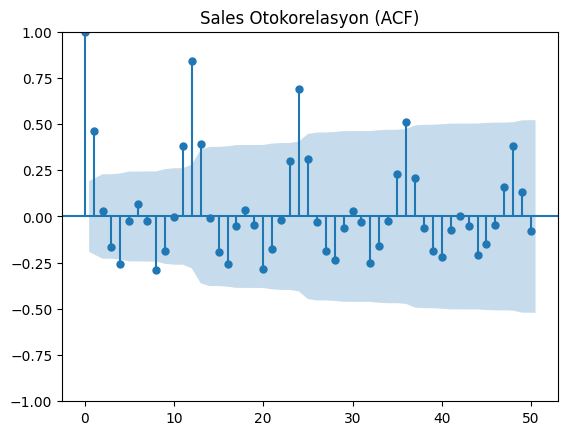

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Sales sütunu için ACF grafiği
# lags=40 veya 50 yaparak birkaç yıllık döngüyü görebiliriz
plot_acf(df["Sales"], lags=50);
plt.title("Sales Otokorelasyon (ACF)");

### Adım 2 - Mevsimsel Farklaştırma (D)

12 aylık periyodla güçlü bir mevsimselliğimiz var.

Zaman serisi üzerinde **lag 12'nin mevsimsel farklaştırmasını** yapın, farklaştırılmış veriyi çizin ve ACF grafiğini (+ADF testi) tekrar kontrol edin.

NaN'ları düşürmeyi unutmayın.

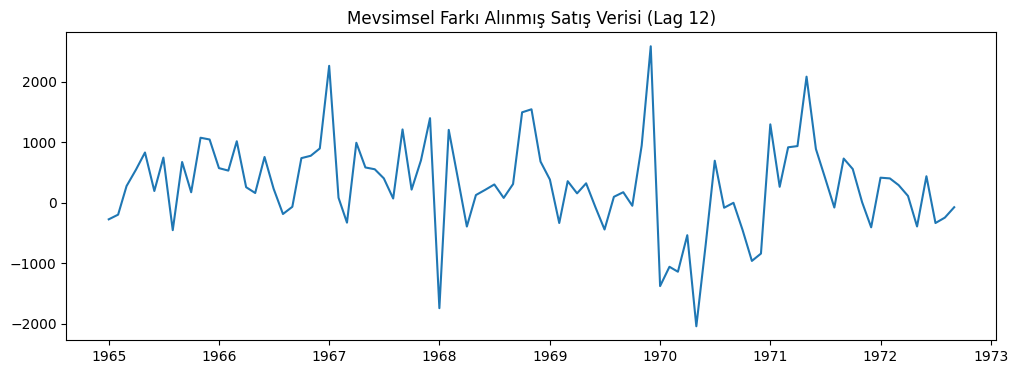

ADF p-değeri: 2.0605796968136632e-11


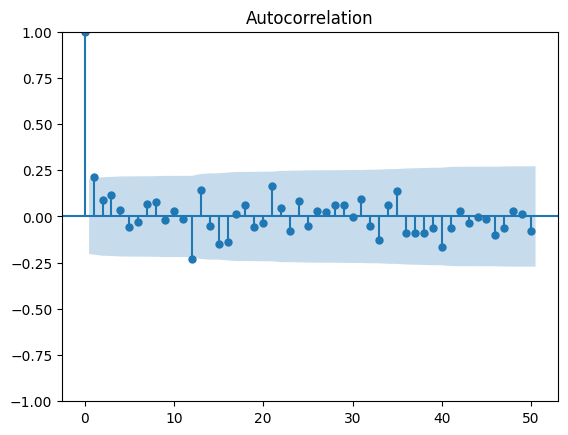

In [21]:
# 12 aylık mevsimsel fark alımı
df_seasonal_diff = df["Sales"].diff(12).dropna()

# Zaman Serisi Grafiği
plt.figure(figsize=(12, 4))
plt.plot(df_seasonal_diff)
plt.title("Mevsimsel Farkı Alınmış Satış Verisi (Lag 12)")
plt.show()

# ACF Grafiği
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_seasonal_diff, lags=50);

# ADF Testi
from statsmodels.tsa.stattools import adfuller
adf_res = adfuller(df_seasonal_diff)
print(f"ADF p-değeri: {adf_res[1]}")

☝️ TS'yi durağanlaştırmak için tek bir mevsimsel farklaştırma yeterli görünüyor.
SARIMA(p,d,q, P,D,Q,m) için D=1 (1 mevsimsel fark) ve m=12 (mevsimsellik = 12)

### Adım 3 - Farklaştırma (d)

Zaman serisi hala durağan değilse, *farklaştırma* yoluyla durağanlaştırılması gerekir. Bu, her değer ile bir önceki arasındaki farkı almak (*birinci fark*) anlamına gelir.

Mevsimselliği çıkardıktan sonra daha fazla farklaştırmaya ihtiyacımız var mı?

diff(12) seriniz üzerinde ek bir birinci derece diff(1) çalıştırdıktan sonra ACF ve ADF'yi kontrol edin.

Çifte Fark Sonrası ADF p-değeri: 0.0002650462849293455


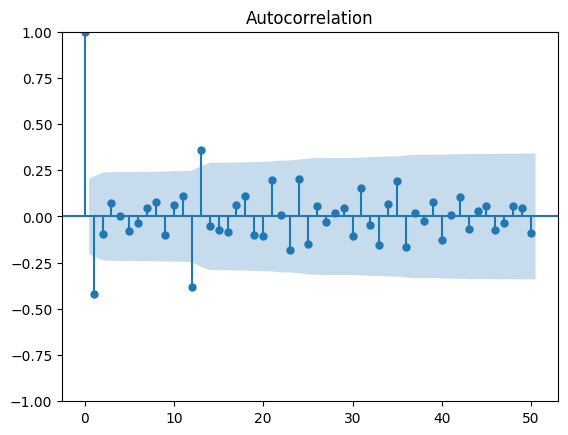

In [22]:
# Mevsimsel fark üzerine birinci derece fark uygulama
df_double_diff = df["Sales"].diff(12).diff(1).dropna()

# ADF Testi
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_double_diff)
print(f"Çifte Fark Sonrası ADF p-değeri: {adf_result[1]}")

# ACF Grafiği
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_double_diff, lags=50);

👉 Ek farklaştırma hem p-değerini hem de ACF'yi daha kötü hale getirdi!
(d=0) ve (D=1) seçebiliriz

### Adım 4 - AR(p, P) ve MA(q, Q) Terimlerini Seç

Şimdi bir AR terimi, MA terimi veya her ikisini de dahil edip etmeyeceğinize karar vermek için ACF ve PACF grafiklerini kullanacaksınız.

- **Tamamen farklaştırılmış** serinize uygulanan otokorelasyon grafiği ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bir MA sayısı (`q`) seçmenize olanak tanır
- MA($\color{blue}{q}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{blue}{ACF}$'sinin kestiği lag sayısı


- **Tamamen farklaştırılmış** serinize uygulanan kısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) AR (`p`) seçmenize olanak tanır
- AR($\color{red}{p}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{red}{PACF}$'sinin kestiği lag sayısı

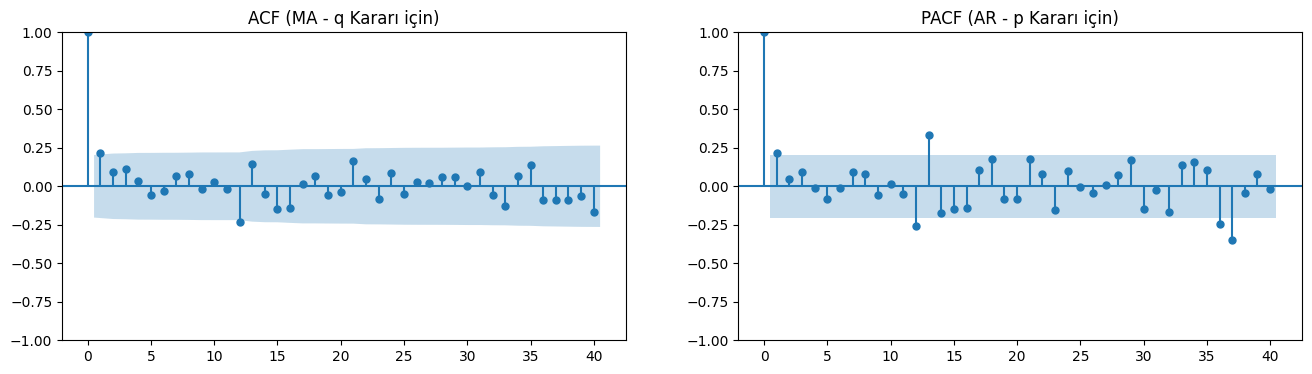

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Çifte farkı alınmış veri (Önceki adımda df_double_diff olarak tanımlamıştık)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF -> MA (q) terimini belirler
plot_acf(df_seasonal_diff, lags=40, ax=ax1);
ax1.set_title("ACF (MA - q Kararı için)")

# PACF -> AR (p) terimini belirler
plot_pacf(df_seasonal_diff, lags=40, ax=ax2, method='yw');
ax2.set_title("PACF (AR - p Kararı için)");

☝️ ACF veya PACF'de anlamlı pik yok gibi görünüyor, bu yüzden büyük olasılıkla p=q=0.
SARIMA için ilk tahminimiz bu nedenle d=0, p=q=0, D=1 ve m=12.

P ve Q değerlerini nasıl bulacağız? Burada, `pdarima`'nın bizim için grid_search ile P ve Q için 1 ve 0 değerlerini denemesine izin vereceğiz.
Bu katsayıları kendiniz bulmak istiyorsanız, bazı pratik kurallar için [bunu okuyun](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

👉 Eğitim seti için [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) çalıştırın. seasonal=True, m=12 ve D=1 ayarlayın. p ve q, P ve Q'yu 0'dan 2'ye kadar arayın. Ardından model.summary() ile modelin özetini yazdırın.
`njobs=-1, trace=True, error_action='ignore', suppress_warnings=True` kullanın

In [26]:
import pmdarima as pm

# auto_arima modelini kuruyoruz
model = pm.auto_arima(df_train['Sales'], 
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      d=1,           # Az önce bulduğumuz fark derecesi
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      D=1,           # Mevsimsel fark derecesi
                      m=12,          # Mevsimsellik periyodu (aylık)
                      seasonal=True, 
                      error_action='ignore', 
                      suppress_warnings=True, 
                      trace=True,    # Arama sürecini ekrana yazdırır
                      n_jobs=-1)     # Tüm işlemci çekirdeklerini kullan

# Model özetini görelim
print(model.summary())

/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=971.186, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=960.946, Time=0.59 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=962.899, Time=0.08 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=962.511, Time=1.73 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=963.166, Time=0.54 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=961.809, Time=0.61 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=966.791, Time=0.14 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=957.815, Time=0.38 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=957.181, Time=0.10 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AIC=958.192, Time=0.45 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12]             : AIC=959.555, Time=1.01 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.19 sec


/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[12] intercept   : AIC=959.163, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,1,0)[12]          
Total fit time: 9.994 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -475.591
Date:                            Mon, 09 Feb 2026   AIC                            957.181
Time:                                    15:02:18   BIC                            963.414
Sample:                                01-01-1964   HQIC                           959.614
                                     - 12-01-1969                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

Bulunan en iyi model `ARIMA(0,0,0)(0,1,0)[12]`!
Bu, düşünülen zaman serisinin basit "mevsimsel farklaştırma"nın ötesinde herhangi bir "oto-regresif" veya "hareketli ortalama" modelleme eklemeyi haklı çıkarmadığı anlamına gelir.

Böyle "zayıf" bir model muhtemelen sadece tespit edilen son mevsimsel desenin tekrarını ve ortalama artan trendin uzatılmasını tahmin edecektir. Kontrol edelim

👉 Aşağıdaki üç tahmini kaydetmek için `n_periods` = test setinin uzunluğu ile `model.predict` kullanın
- `central`
- `upper`
- `lower`

Bunları Pandas Series olarak kaydedin ve `y_test`inizle aynı indeks ile indeksleyin

In [27]:
# Test setinin uzunluğunu belirle
n_periods = len(df_test)

# Tahminleri ve güven aralıklarını al
central_values, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# 1. Merkezi Tahmin (Central Forecast)
central = pd.Series(central_values, index=df_test.index)

# 2. Alt ve Üst Sınırlar (Lower & Upper Bounds)
# conf_int bir numpy array döner: [alt_sınır, üst_sınır]
lower = pd.Series(conf_int[:, 0], index=df_test.index)
upper = pd.Series(conf_int[:, 1], index=df_test.index)

/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wit/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


👇 Tahminlerinizi gerçeklikle karşılaştırmak için aşağıdaki hücreyi çalıştırın

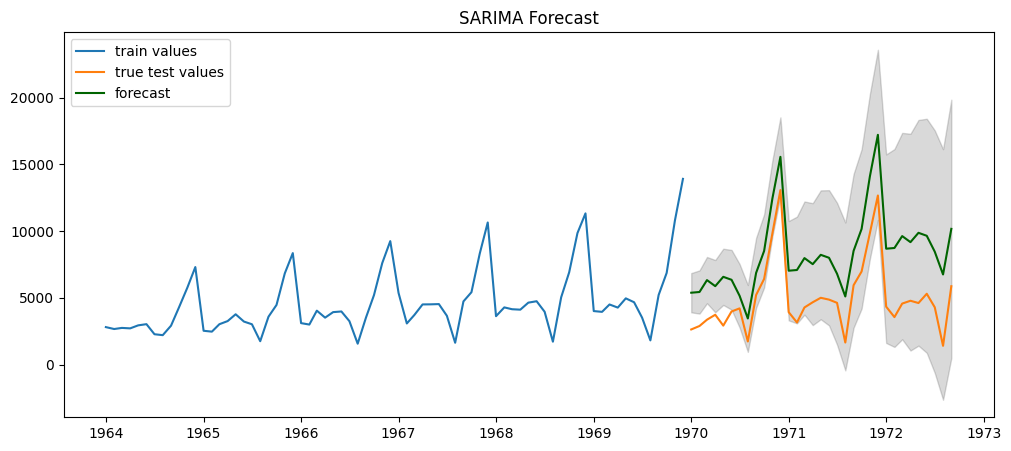

In [28]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 SARIMA'nızda `p`, `d`, `P`, `D`'ye null olmayan değerler atamayı deneyin ve etkileri karşılaştırmak için bu grafiği yeniden çizin!

# İSTEĞE BAĞLI - Makine Öğrenmesi Yaklaşımı

### Sadece 1 aylık tahmin ufku olan model

Şimdi Random Forest gibi doğrusal olmayan bir model uyduruyoruz. Fikir, son değerlerden bir değer tahmin etmektir.

👉 `df`'de `df['Sales']`'ın kaydırılmış versiyonu olan yeni sütunlar oluşturun. Bunu 1'den 12'ye kadar kaydırma ile yapın.

In [29]:
# Orijinal veriyi bozmamak için bir kopya oluşturalım
df_ml = df.copy()

# 1'den 12'ye kadar olan gecikmeleri (lags) ekleyelim
for i in range(1, 13):
    df_ml[f'lag_{i}'] = df_ml['Sales'].shift(i)

# İlk 12 satırda geçmiş veri olmadığı için NaN oluşacaktır, bunları temizleyelim
df_ml.dropna(inplace=True)

# Sonucu kontrol edelim
print(df_ml.head())

            Sales   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  \
Month                                                                       
1965-01-01   2541  7312.0  5764.0  4301.0  2922.0  2212.0  2282.0  3036.0   
1965-02-01   2475  2541.0  7312.0  5764.0  4301.0  2922.0  2212.0  2282.0   
1965-03-01   3031  2475.0  2541.0  7312.0  5764.0  4301.0  2922.0  2212.0   
1965-04-01   3266  3031.0  2475.0  2541.0  7312.0  5764.0  4301.0  2922.0   
1965-05-01   3776  3266.0  3031.0  2475.0  2541.0  7312.0  5764.0  4301.0   

             lag_8   lag_9  lag_10  lag_11  lag_12  
Month                                               
1965-01-01  2946.0  2721.0  2755.0  2672.0  2815.0  
1965-02-01  3036.0  2946.0  2721.0  2755.0  2672.0  
1965-03-01  2282.0  3036.0  2946.0  2721.0  2755.0  
1965-04-01  2212.0  2282.0  3036.0  2946.0  2721.0  
1965-05-01  2922.0  2212.0  2282.0  3036.0  2946.0  


👉 Kaydırılmış özelliklerinize dayalı olarak Satışları tahmin etmek için bir `random forest` algoritması oluşturun (eğitmeyin)

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor modelini oluşturuyoruz
# n_estimators: Kaç tane karar ağacı kullanılacağı (100 genelde iyi bir başlangıçtır)
# random_state: Sonuçların her çalıştırdığında aynı çıkması için (reproducibility)
# max_depth: Ağaçların karmaşıklığını kontrol eder (overfitting'i önlemek için)

model_rf = RandomForestRegressor(n_estimators=100, 
                                 max_depth=10, 
                                 random_state=42, 
                                 n_jobs=-1)

# Model şu an boş bir beyin gibi, eğitilmeyi bekliyor.

👉 Test etmek için aşağıdaki fonksiyonu kullanabilirsiniz. Gerçek y değerlerini (`data` NumPy array olmalı), test örneklerinin indekslerini (`test_indexes`), tahmin ediciyi (`predictor`: random forest algoritmanız) ve kaydırılmış sütunları (`full_X` NumPy array olmalı) alır.

In [31]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [32]:
import numpy as np

# 1. Verileri Hazırlama
# Hedef değişken (Sales)
y_all = df_ml['Sales'].values

# Özellikler (Lag_1'den Lag_12'ye kadar olan sütunlar)
# .iloc[:, 1:] Sales dışındaki tüm lag sütunlarını alır
X_all = df_ml.drop(columns=['Sales']).values

# 2. Test İndekslerini Belirleme
# Orijinal df_test içindeki tarihlerin df_ml içindeki tam konumlarını bulmalıyız
test_indexes = [df_ml.index.get_loc(date) for date in df_test.index if date in df_ml.index]

# 3. Performansı Değerlendir
# 'model_rf' önceki adımda oluşturduğumuz (fit edilmemiş) Random Forest nesnesidir
ground_truth, predictions, mape = evaluate_performance_month_prediction(
    y_all, 
    test_indexes, 
    model_rf, 
    X_all
)

# 4. Sonuçları Yazdır
print(f"Random Forest MAPE (Hata Payı): {mape * 100:.2f}%")

Random Forest MAPE (Hata Payı): 15.95%


# İki modeli kıyaslama

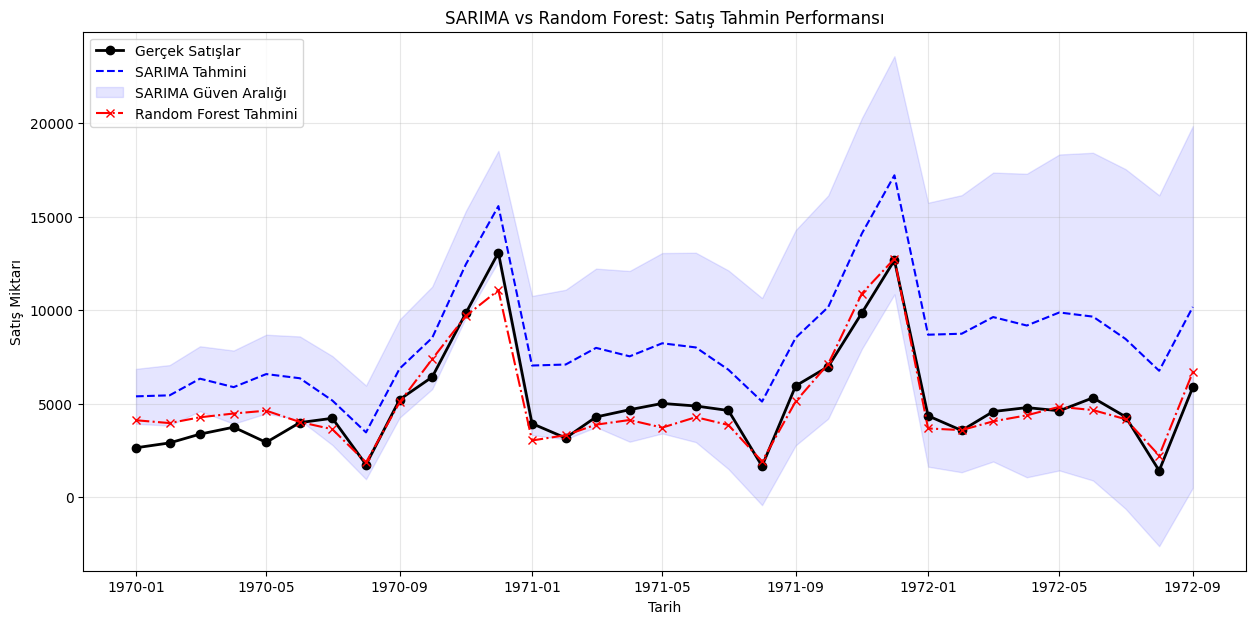

Random Forest MAPE: %15.95
SARIMA MAPE: %86.24


In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# 1. Gerçek Veriler (Test Seti)
plt.plot(df_test.index, ground_truth, label='Gerçek Satışlar', color='black', linewidth=2, marker='o')

# 2. SARIMA Tahmini (Önceki adımlarda hesapladığımız 'central')
plt.plot(central.index, central, label='SARIMA Tahmini', color='blue', linestyle='--')
plt.fill_between(central.index, lower, upper, color='blue', alpha=0.1, label='SARIMA Güven Aralığı')

# 3. Random Forest Tahmini
plt.plot(df_test.index, predictions, label='Random Forest Tahmini', color='red', linestyle='-.', marker='x')

plt.title('SARIMA vs Random Forest: Satış Tahmin Performansı')
plt.xlabel('Tarih')
plt.ylabel('Satış Miktarı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# MAPE Karşılaştırması
print(f"Random Forest MAPE: %{mape * 100:.2f}")
# SARIMA MAPE'sini de hesaplayalım (central üzerinden)
sarima_mape = np.mean(np.abs(central - ground_truth) / np.abs(ground_truth))
print(f"SARIMA MAPE: %{sarima_mape * 100:.2f}")

# Feature Importance (Random Forest)

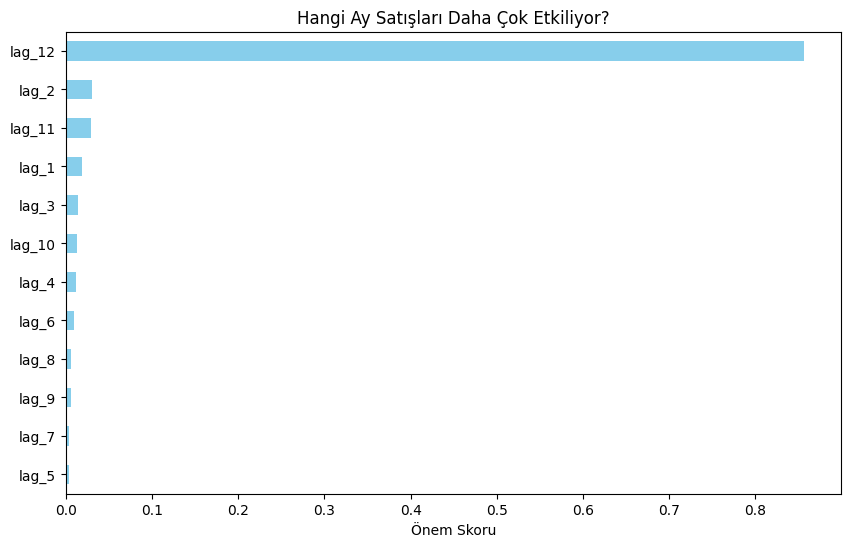

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Özellik isimlerini alalım (lag_1, lag_2... lag_12)
features = df_ml.drop(columns=['Sales']).columns

# Önem derecelerini çekelim
importances = model_rf.feature_importances_

# Görselleştirelim
feature_importance_df = pd.Series(importances, index=features).sort_values(ascending=True)
feature_importance_df.plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title('Hangi Ay Satışları Daha Çok Etkiliyor?')
plt.xlabel('Önem Skoru')
plt.show()

# Correlation Matrix

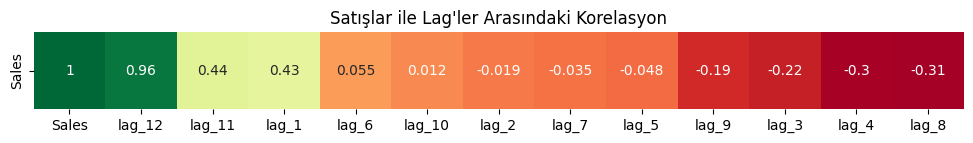

In [35]:
import seaborn as sns

plt.figure(figsize=(12, 1))
# Satışların diğer lag'lerle korelasyonu
sns.heatmap(df_ml.corr()[['Sales']].sort_values(by='Sales', ascending=False).T, 
            annot=True, cmap='RdYlGn', cbar=False)
plt.title("Satışlar ile Lag'ler Arasındaki Korelasyon")
plt.show()

# Permutation Importance

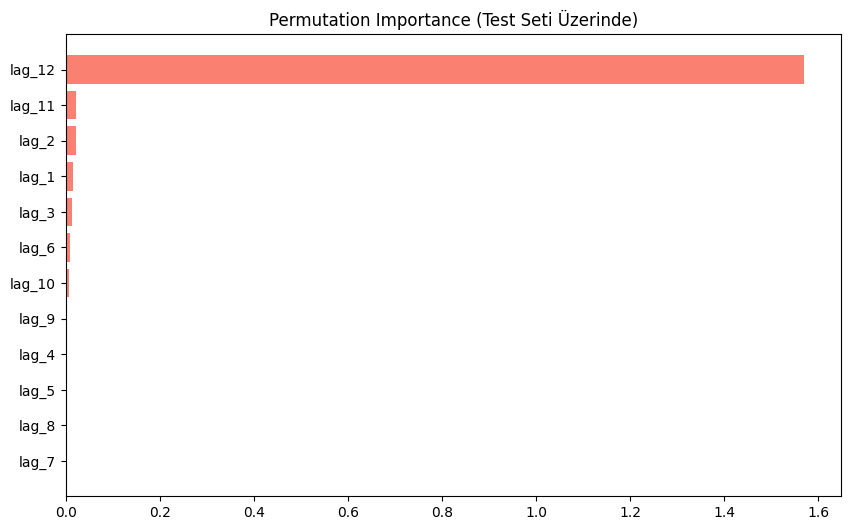

In [36]:
from sklearn.inspection import permutation_importance

# Modeli eğitmiştik, şimdi test verisi üzerinde önem derecesini ölçelim
result = permutation_importance(model_rf, X_all[test_indexes], y_all[test_indexes], 
                                n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(features[perm_sorted_idx], result.importances_mean[perm_sorted_idx], color='salmon')
plt.title("Permutation Importance (Test Seti Üzerinde)")
plt.show()

# SHAP Değerleri (Açıklanabilir Yapay Zeka)
SHAP, günümüzdeki en gelişmiş yöntemdir. Sadece "bu özellik önemli" demez, aynı zamanda "bu özellik değeri yüksek olduğunda tahmini şu kadar artırdı" der.

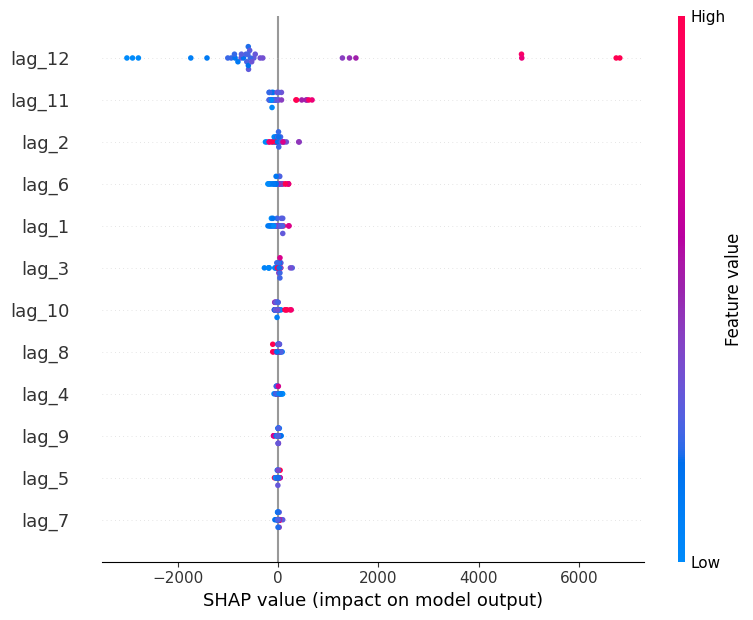

In [37]:
import shap

# SHAP açıklayıcısını oluştur (TreeExplainer ağaç modelleri için çok hızlıdır)
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_all[test_indexes])

# Özet Grafiği (Summary Plot)
shap.summary_plot(shap_values, X_all[test_indexes], feature_names=features)

Modelimizi iyileştirmek için özellik mühendisliği yapabiliriz. Random forest'ı eğitmek için kullanılan verilere hareketli ortalamalar ekleyeceksiniz.

`df`'de 3 yeni sütun oluşturmayı deneyin: biri 12 pencereli `df[Sales]`'ın hareketli ortalaması, biri 3 pencereli ve biri 2 pencereli. Bu, trendi izole etme ve algoritmanın öğrenmesine izin verme etkisine sahip olacaktır. Bu verileri çizin.


In [38]:
# 12, 3 ve 2 aylık pencerelerle hareketli ortalamalar
df_ml['rolling_12'] = df['Sales'].rolling(window=12).mean()
df_ml['rolling_3'] = df['Sales'].rolling(window=3).mean()
df_ml['rolling_2'] = df['Sales'].rolling(window=2).mean()

# Hareketli ortalamalar başlangıçta NaN üretir, bunları temizleyelim
df_ml.dropna(inplace=True)

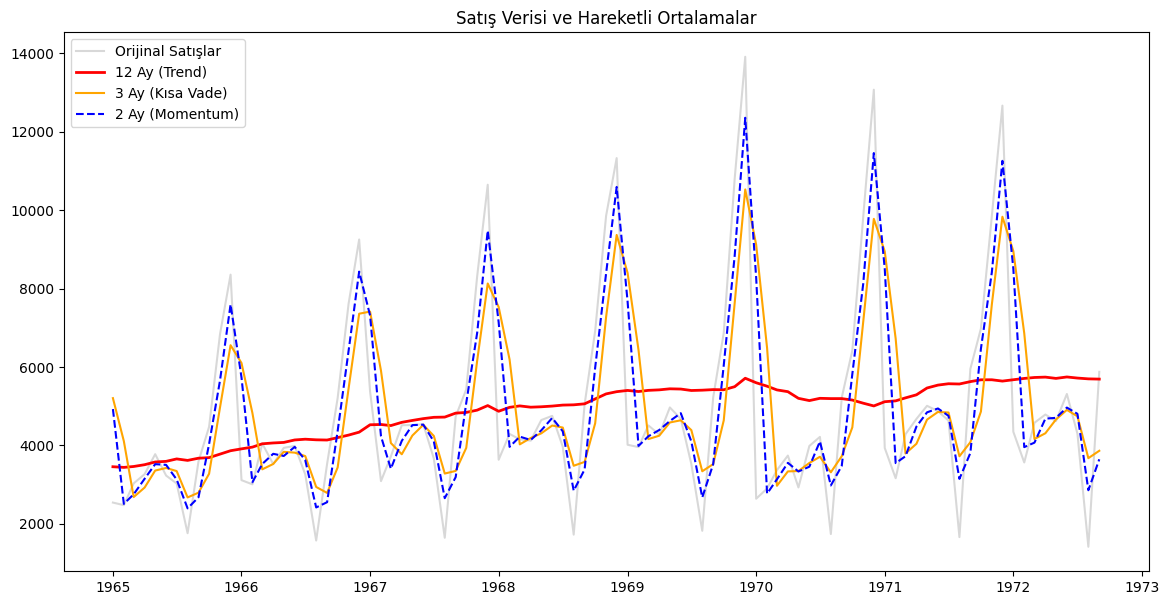

In [39]:
# Etkiyi görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_ml.index, df_ml['Sales'], label='Orijinal Satışlar', alpha=0.3, color='gray')
plt.plot(df_ml.index, df_ml['rolling_12'], label='12 Ay (Trend)', color='red', linewidth=2)
plt.plot(df_ml.index, df_ml['rolling_3'], label='3 Ay (Kısa Vade)', color='orange', linewidth=1.5)
plt.plot(df_ml.index, df_ml['rolling_2'], label='2 Ay (Momentum)', color='blue', linestyle='--')

plt.title('Satış Verisi ve Hareketli Ortalamalar')
plt.legend()
plt.show()

İstatistiksel olarak bir AR sürecini optimize eden üstel hareketli ortalama kullanarak daha güçlü bir yumuşatma tahmincisi de ekleyebilirsiniz (ipucu: 2, 3 ve 12 `halflife` ile `.ewm` metodu). Bu verileri çizin.

EWM (Exponential Weighted Moving Average), basit hareketli ortalamadan (SMA) daha "akıllıdır" çünkü verinin yaşına göre ağırlık verir.

SMA tüm geçmişe eşit önem verirken, EWM yakın geçmişe daha fazla ağırlık verir. Bu da onu bir AR (Auto-Regressive) sürecini modellemek için mükemmel bir araç yapar; çünkü zaman serilerinde genellikle "dün", "evvelsi günden" daha bilgilendiricidir.

halflife (yarı ömür) parametresi, ağırlığın ne kadar hızlı azalacağını belirler. Örneğin halflife=3 demek, 3 birim zaman geçtikten sonra o verinin etkisinin yarıya inmesi demektir.

1. EWM Özelliklerini Oluşturma
Hemen halflife değerlerini kullanarak yeni özelliklerimizi ekleyelim:

In [41]:
# 2, 3 ve 12 halflife değerleri ile Üstel Hareketli Ortalama (EWM)
df_ml['ewm_2'] = df['Sales'].ewm(halflife=2).mean()
df_ml['ewm_3'] = df['Sales'].ewm(halflife=3).mean()
df_ml['ewm_12'] = df['Sales'].ewm(halflife=12).mean()

# NaN değerleri temizleyelim (EWM genelde NaN üretmez ama index uyumu için kontrol iyidir)
df_ml.dropna(inplace=True)

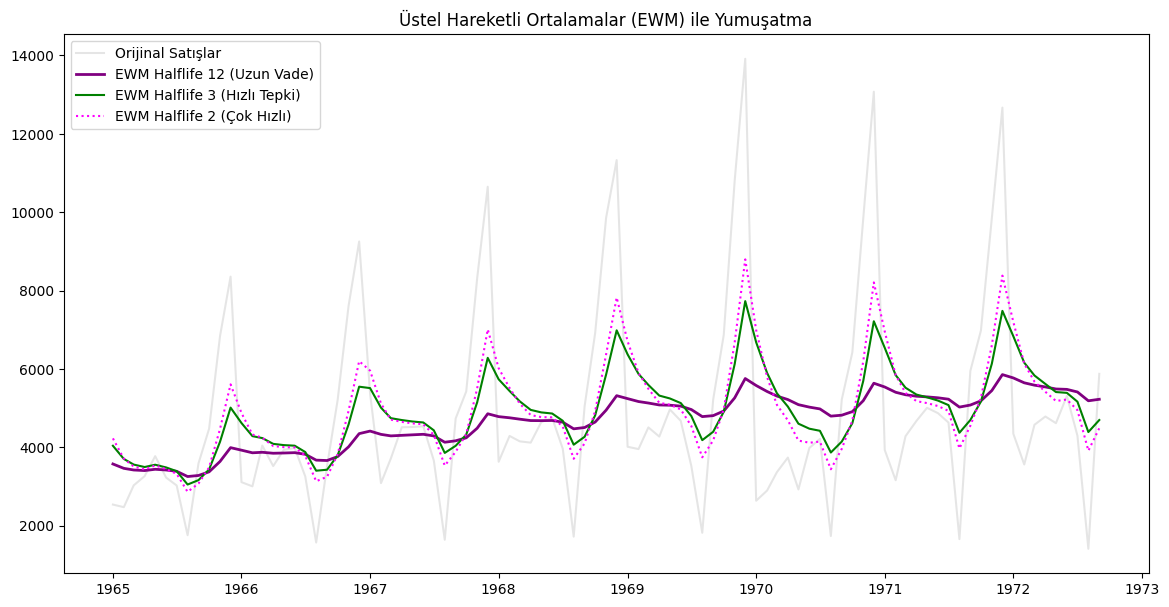

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(df_ml.index, df_ml['Sales'], label='Orijinal Satışlar', alpha=0.2, color='gray')

# EWM Çizgileri
plt.plot(df_ml.index, df_ml['ewm_12'], label='EWM Halflife 12 (Uzun Vade)', color='purple', linewidth=2)
plt.plot(df_ml.index, df_ml['ewm_3'], label='EWM Halflife 3 (Hızlı Tepki)', color='green', linewidth=1.5)
plt.plot(df_ml.index, df_ml['ewm_2'], label='EWM Halflife 2 (Çok Hızlı)', color='magenta', linestyle=':')

plt.title('Üstel Hareketli Ortalamalar (EWM) ile Yumuşatma')
plt.legend()
plt.show()

Daha iyi bir MAPE görmelisiniz!

Her özelliğin önemine bakmayı deneyin. Ne buluyorsunuz?


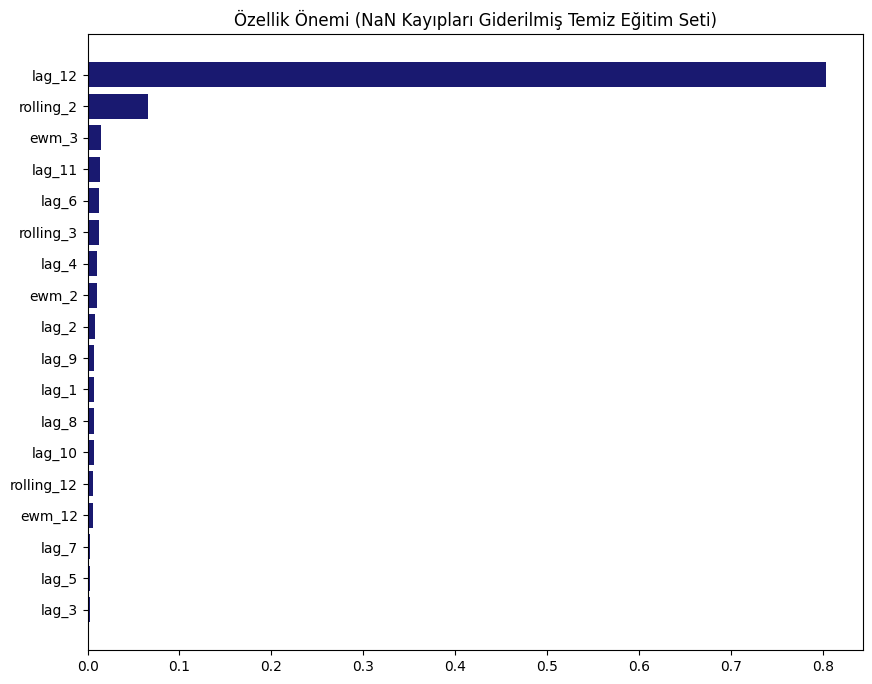

In [45]:
# 1. Eğitim indekslerinden df_ml'de bulunmayanları (NaN nedeniyle sildiklerimizi) eleyelim
valid_train_indexes = df_train.index.intersection(df_ml.index)

# 2. Şimdi bu temizlenmiş indekslerle veriyi çekelim
X_train_clean = df_ml.loc[valid_train_indexes].drop(columns=['Sales']).values
y_train_clean = df_ml.loc[valid_train_indexes]['Sales'].values
feature_names = df_ml.drop(columns=['Sales']).columns

# 3. Modeli sadece bu eğitim verisiyle eğit
model_rf.fit(X_train_clean, y_train_clean)

# 4. Önem skorlarını al ve görselleştir
importances = model_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='midnightblue')
plt.title('Özellik Önemi (NaN Kayıpları Giderilmiş Temiz Eğitim Seti)')
plt.show()

### Örneklem-Dışı Tahmin Modelleri

Şimdi "örneklem-dışı" tahminde SARIMA'yı geçmeyi deneyelim.

👉 _Her tahmin ufku için bir model eğitin_ (`1`-aylık ufuktan `len(y_test)` aya kadar)
👉 MAPE'yi değerlendirin ve SARIMA ile karşılaştırın

In [46]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Sonuçları saklamak için
ml_predictions = []
horizons = range(1, len(df_test) + 1)

# Eğitim verisinin sonundaki 'mevcut' özellikleri alalım (X_test'in ilk satırı gibi)
# Sızıntı olmaması için df_train'in sonundaki lag/rolling değerlerini baz alıyoruz
latest_features = df_ml.loc[valid_train_indexes].iloc[-1:].drop(columns=['Sales']).values

for h in horizons:
    # Hedef değişkeni 'h' kadar kaydırıyoruz (Direct Forecasting)
    # y_t+h'yi bugünle tahmin etmek için Sales'i h kadar GERİYE çekiyoruz
    y_target = df_ml['Sales'].shift(-h).dropna()
    X_target = df_ml.drop(columns=['Sales']).loc[y_target.index].values
    
    # Modeli eğit
    rf_horizon = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_horizon.fit(X_target, y_target)
    
    # En son bilinen veriden 'h' ay sonrasını tahmin et
    pred = rf_horizon.predict(latest_features)[0]
    ml_predictions.append(pred)

# MAPE Hesaplama
ml_predictions = np.array(ml_predictions)
actuals = df_test['Sales'].values
ml_mape = np.mean(np.abs(ml_predictions - actuals) / actuals)

print(f"Direct RF MAPE: %{ml_mape * 100:.2f}")
print(f"SARIMA MAPE: %{sarima_mape * 100:.2f}")

Direct RF MAPE: %5.39
SARIMA MAPE: %86.24


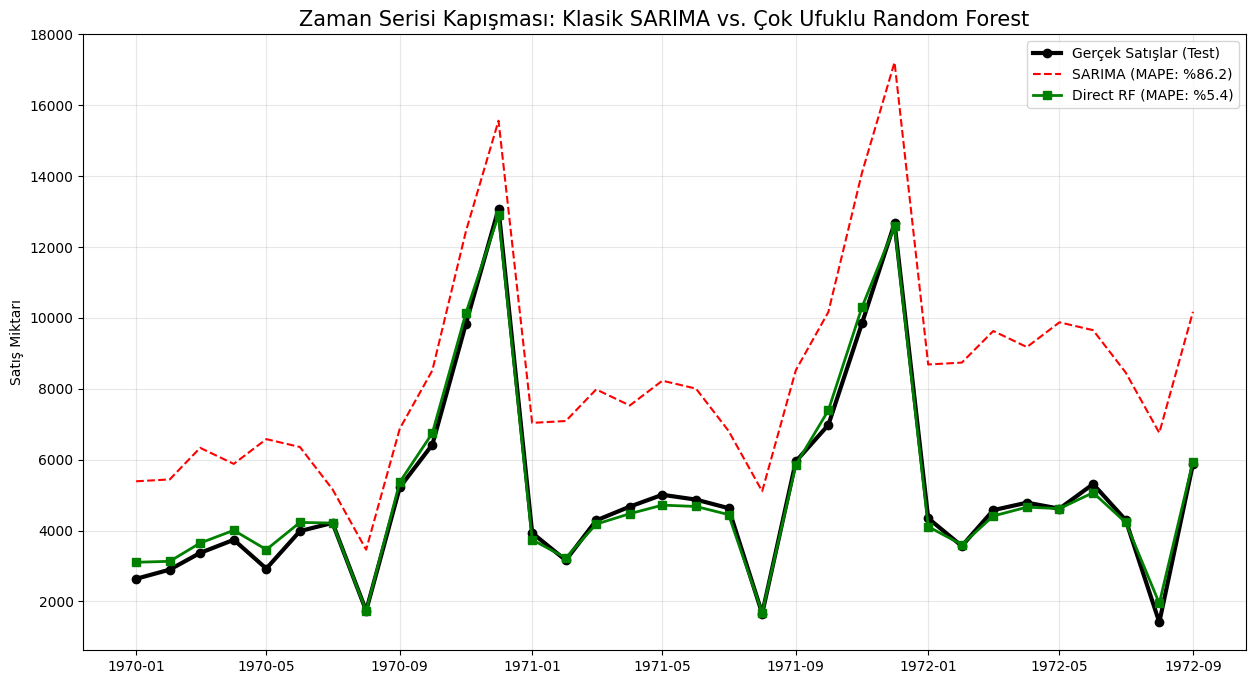

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# 1. Gerçek Satışlar
plt.plot(df_test.index, df_test['Sales'], label='Gerçek Satışlar (Test)', color='black', linewidth=3, marker='o')

# 2. SARIMA Tahmini (Hüsranla sonuçlanan)
plt.plot(df_test.index, central, label=f'SARIMA (MAPE: %{sarima_mape*100:.1f})', color='red', linestyle='--')

# 3. Direct Random Forest Tahmini (Şampiyon)
plt.plot(df_test.index, ml_predictions, label=f'Direct RF (MAPE: %{ml_mape*100:.1f})', color='green', linewidth=2, marker='s')

plt.title('Zaman Serisi Kapışması: Klasik SARIMA vs. Çok Ufuklu Random Forest', fontsize=15)
plt.ylabel('Satış Miktarı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()